# Chicago Divvy Bike-sharing program bike usage prediction.

## Team members
**Hang Tian**\
github id:ht6631

Mengqi Li\
github id:Adalmqqqq

Vaishnavi Meka\
github id:vaishnavimeka27

## Overview
#### - What are you trying to do? Articulate your objectives using absolutely no jargon.
We are working on this project that combines weather data, holiday information and aggregated bike trip data (as trip counts) to predict bike usage daily of the bike-sharing program (divvy) in Chicago, IL.

#### - What is new in your approach and why do you think it will be successful? 
Instead of merely aggregating bike trip data periodically with weather data, we added other features like user type (member or non-member), bike type and geographic information.

#### - Who cares? If you are successful, what difference will it make? Importantly, who is your primary stakeholder, and what specific need are you addressing?
Our main stakeholder is the Chicago Department of Transportation (CDOT). Our predicted bike usage information can not only guide the planning and allocation of shared bike resources, but also support futural decisions about where to expand or adjust services to integrate with other modes of transportation. To summarize, our project could help optimize the city’s bike-sharing infrastructure.

## Data
#### 1. Bike-sharing trip data: https://divvybikes.com/system-data  ->  https://divvy-tripdata.s3.amazonaws.com/index.html
Since the Divvy bike-sharing program is ran by CDOT (Chicago Department of Transportation), this dataset is highly reliable. We used bike trip data from 2022 to 2023 for this project.
#### 2. Chicago neighbourhoods shapefile: https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Neighborhoods/bbvz-uum9
This dataset comes from Chicago open data portal, it's well maintained by Chicago government and highly reliable .
#### 3. Holiday information
#### 4. Daily weather data

## Preprocessing

### 1. Aggregation of bike trips

The original bike trip data is one row per one trip records including member type, bike type, start and end time and location. If the start or end location is at stations, that information will be recorded in related variables such as "start_station_id", "end_station_id".\

The image attached below depict how the original data looks like.

<img src="Images/bike_trip.png" alt="Original bike trip data" />

### 2. Geographic aggregation

We first plan to aggregate them as hourly usage counts with date information, also group by user type, bike types as features. Besides, we have concidered aggregating the records with their start and end locations.

Most of the trips are both started and ended at stations (about 80%) while there are records either not start or end at stations. There are 2000+ unique bike stations involved in these records. That will be a huge number of combination of we aggregate trips per stations (start and end), so we first overlapped the stations with Chicago neighbourhoods. Below are the maps. The value of legend shows how many total start and end cases happened at the very station or within each polygon.

<img src="Images/Bike_stations.png" alt="Bike stations over Chicago" />

<img src="Images/Chicago_neighbor.png" alt="Total Usage Counts per neighbourhoods" />

Among these neighbourhoods, five of these neighborhoods clearly have significantly higher usage counts compared to the others as the box plot shows. They are identified as hot zones. Further geographic aggregation of bike tirps will count on if the start and end points are within these hot zones.

<img src="Images/boxplot.png" alt="Boxplot of usage sum within each neighborhoods" />

<img src="Images/hotzone_stations.png" alt="Stations within Hot zones" />

### 3. Merging with holiday information and weather data

__For everyday in 2022 and 2023, we labeld if it is during weekday and if that day is a holiday when people don't need to work. The aggregated table is shown as below.__

In [1]:
import pandas as pd
usage_count=pd.read_csv('data/usage_count_date.csv')
usage_count.drop('Unnamed: 0',axis=1,inplace=True)
usage_count

,rideable_type,member_casual,date,hour,start_in_hot_zones,end_in_hot_zones,at_stations,count,ISweekday,ISholiday
0,classic_bike,casual,2022-01-01,0,0.0,0.0,1,22,0,1
1,classic_bike,casual,2022-01-01,0,0.0,1.0,1,7,0,1
2,classic_bike,casual,2022-01-01,0,1.0,0.0,1,6,0,1
3,classic_bike,casual,2022-01-01,0,1.0,1.0,1,14,0,1
4,classic_bike,casual,2022-01-01,1,0.0,0.0,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...
333304,electric_bike,member,2023-12-31,23,0.0,0.0,1,9,0,0
333305,electric_bike,member,2023-12-31,23,0.0,1.0,1,2,0,0
333306,electric_bike,member,2023-12-31,23,1.0,0.0,1,1,0,0
333307,electric_bike,member,2023-12-31,23,1.0,1.0,0,12,0,0


__Create a daily usage count__

In [2]:
usage_count_daily=usage_count.groupby(['rideable_type','member_casual','date','start_in_hot_zones','end_in_hot_zones','at_stations','ISweekday','ISholiday']).sum()
usage_count_daily.reset_index(inplace=True)
usage_count_daily.drop('hour',axis=1,inplace=True)
usage_count_daily

,rideable_type,member_casual,date,start_in_hot_zones,end_in_hot_zones,at_stations,ISweekday,ISholiday,count
0,classic_bike,casual,2022-01-01,0.0,0.0,0,0,1,3
1,classic_bike,casual,2022-01-01,0.0,0.0,1,0,1,192
2,classic_bike,casual,2022-01-01,0.0,1.0,1,0,1,80
3,classic_bike,casual,2022-01-01,1.0,0.0,1,0,1,87
4,classic_bike,casual,2022-01-01,1.0,1.0,0,0,1,3
...,...,...,...,...,...,...,...,...,...
16864,electric_bike,member,2023-12-31,0.0,0.0,1,0,0,240
16865,electric_bike,member,2023-12-31,0.0,1.0,1,0,0,103
16866,electric_bike,member,2023-12-31,1.0,0.0,1,0,0,93
16867,electric_bike,member,2023-12-31,1.0,1.0,0,0,0,179


__Besides, the daily weather data for year 2022 and 2023 are retrieved and saved as csv files in "data" folder__

In [3]:
weather_2022=pd.read_csv('data/chicago2022.csv')
weather_2022.drop('name',axis=1,inplace=True)
weather_2023=pd.read_csv('data/chicago2023.csv')
weather_2023.drop('name',axis=1,inplace=True)
weather_2023.head()

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,2023-01-01,44.2,37.1,41.1,41.3,32.0,38.1,38.1,89.1,0.115,...,2.0,1,10,2023-01-01T07:18:22,2023-01-01T16:30:02,0.32,"Rain, Overcast",Cloudy skies throughout the day with early mor...,rain,"72534014819,KORD,KMDW,72530094846,F1983,744665..."
1,2023-01-02,43.1,31.9,38.1,39.6,31.5,34.7,35.3,90.0,0.000,...,2.2,1,10,2023-01-02T07:18:26,2023-01-02T16:30:54,0.36,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,F1983,F7086,..."
2,2023-01-03,46.6,39.4,42.9,45.2,32.6,39.4,41.7,95.4,0.952,...,0.8,1,10,2023-01-03T07:18:29,2023-01-03T16:31:48,0.39,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,rain,"72534014819,KORD,KMDW,72530094846,F1983,F7086,..."
3,2023-01-04,45.1,33.5,37.0,41.3,25.4,30.8,32.2,82.7,0.008,...,0.6,0,10,2023-01-04T07:18:29,2023-01-04T16:32:44,0.42,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"72534014819,KORD,KMDW,72530094846,F1983,F7086,..."
4,2023-01-05,34.2,32.1,33.0,28.5,22.7,25.4,28.0,81.5,0.004,...,1.5,1,10,2023-01-05T07:18:26,2023-01-05T16:33:41,0.46,"Snow, Rain, Overcast",Cloudy skies throughout the day with morning r...,snow,"72534014819,KORD,KMDW,72530094846,F1983,F7086,..."


In [7]:
weather = pd.concat([weather_2022, weather_2023], ignore_index=True)
weather

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,2022-01-01,40.9,29.6,34.8,33.4,16.7,24.3,29.7,81.7,0.090,...,0.5,0,NaN,2022-01-01T07:18:23,2022-01-01T16:30:14,0.96,"Snow, Rain, Overcast",Cloudy skies throughout the day with rain or s...,snow,"72534014819,AP878,KORD,KMDW,72530094846,F1983,..."
1,2022-01-02,29.1,15.9,23.5,20.7,6.8,13.0,16.1,73.1,0.032,...,2.7,2,NaN,2022-01-02T07:18:27,2022-01-02T16:31:07,0.00,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with early mo...,snow,"72534014819,AP878,KORD,KMDW,72530094846,F1983,..."
2,2022-01-03,23.5,10.3,17.2,13.2,-0.2,6.9,5.7,61.3,0.000,...,5.0,3,NaN,2022-01-03T07:18:28,2022-01-03T16:32:01,0.03,Clear,Clear conditions throughout the day.,clear-day,"72534014819,KORD,KMDW,72530094846,F1983,744665..."
3,2022-01-04,35.4,23.4,29.8,25.2,12.8,19.8,19.5,65.3,0.000,...,3.7,2,NaN,2022-01-04T07:18:28,2022-01-04T16:32:57,0.06,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,F1983,744665..."
4,2022-01-05,34.7,13.4,19.7,24.2,-6.4,3.7,10.3,66.4,0.000,...,3.5,2,NaN,2022-01-05T07:18:25,2022-01-05T16:33:54,0.10,Overcast,Cloudy skies throughout the day.,cloudy,"72534014819,KORD,KMDW,72530094846,F1983,744665..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2023-12-27,43.4,31.3,38.2,37.0,29.1,33.1,31.5,76.9,0.000,...,1.8,1,10.0,2023-12-27T07:17:20,2023-12-27T16:25:58,0.52,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,F1983,744665..."
726,2023-12-28,42.8,37.3,40.0,37.5,30.1,33.4,35.7,84.7,0.119,...,1.0,1,10.0,2023-12-28T07:17:37,2023-12-28T16:26:41,0.56,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"72534014819,KORD,KMDW,72530094846,F1983,744665..."
727,2023-12-29,42.8,32.3,39.6,37.1,28.2,33.2,36.7,89.2,0.106,...,0.8,0,10.0,2023-12-29T07:17:51,2023-12-29T16:27:25,0.59,"Rain, Overcast",Cloudy skies throughout the day with rain clea...,rain,"72534014819,KORD,KMDW,72530094846,F1983,744665..."
728,2023-12-30,37.5,28.2,33.1,33.5,21.4,26.9,29.6,86.8,0.000,...,2.2,1,10.0,2023-12-30T07:18:03,2023-12-30T16:28:12,0.62,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72534014819,KORD,KMDW,72530094846,F1983,744665..."


In [8]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   datetime          730 non-null    object 
 1   tempmax           730 non-null    float64
 2   tempmin           730 non-null    float64
 3   temp              730 non-null    float64
 4   feelslikemax      730 non-null    float64
 5   feelslikemin      730 non-null    float64
 6   feelslike         730 non-null    float64
 7   dew               730 non-null    float64
 8   humidity          730 non-null    float64
 9   precip            730 non-null    float64
 10  precipprob        730 non-null    int64  
 11  precipcover       730 non-null    float64
 12  preciptype        304 non-null    object 
 13  snow              730 non-null    float64
 14  snowdepth         730 non-null    float64
 15  windgust          729 non-null    float64
 16  windspeed         730 non-null    float64
 1

In [9]:
usage_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333309 entries, 0 to 333308
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   rideable_type       333309 non-null  object 
 1   member_casual       333309 non-null  object 
 2   date                333309 non-null  object 
 3   hour                333309 non-null  int64  
 4   start_in_hot_zones  333309 non-null  float64
 5   end_in_hot_zones    333309 non-null  float64
 6   at_stations         333309 non-null  int64  
 7   count               333309 non-null  int64  
 8   ISweekday           333309 non-null  int64  
 9   ISholiday           333309 non-null  int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 25.4+ MB


In [10]:
usage_count['date'] = pd.to_datetime(usage_count['date']).dt.date
usage_count_daily['date'] = pd.to_datetime(usage_count_daily['date']).dt.date
weather['datetime'] = pd.to_datetime(weather['datetime']).dt.date

In [11]:
data_hourly = pd.merge(usage_count, weather, left_on='date', right_on='datetime', how='inner')
data_daily = pd.merge(usage_count_daily, weather, left_on='date', right_on='datetime', how='inner')
data_hourly.drop('datetime', axis=1, inplace=True)
data_daily.drop('datetime', axis=1, inplace=True)
data_daily.head()

,rideable_type,member_casual,date,start_in_hot_zones,end_in_hot_zones,at_stations,ISweekday,ISholiday,count,tempmax,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,classic_bike,casual,2022-01-01,0.0,0.0,0,0,1,3,40.9,...,0.5,0,NaN,2022-01-01T07:18:23,2022-01-01T16:30:14,0.96,"Snow, Rain, Overcast",Cloudy skies throughout the day with rain or s...,snow,"72534014819,AP878,KORD,KMDW,72530094846,F1983,..."
1,classic_bike,casual,2022-01-01,0.0,0.0,1,0,1,192,40.9,...,0.5,0,NaN,2022-01-01T07:18:23,2022-01-01T16:30:14,0.96,"Snow, Rain, Overcast",Cloudy skies throughout the day with rain or s...,snow,"72534014819,AP878,KORD,KMDW,72530094846,F1983,..."
2,classic_bike,casual,2022-01-01,0.0,1.0,1,0,1,80,40.9,...,0.5,0,NaN,2022-01-01T07:18:23,2022-01-01T16:30:14,0.96,"Snow, Rain, Overcast",Cloudy skies throughout the day with rain or s...,snow,"72534014819,AP878,KORD,KMDW,72530094846,F1983,..."
3,classic_bike,casual,2022-01-01,1.0,0.0,1,0,1,87,40.9,...,0.5,0,NaN,2022-01-01T07:18:23,2022-01-01T16:30:14,0.96,"Snow, Rain, Overcast",Cloudy skies throughout the day with rain or s...,snow,"72534014819,AP878,KORD,KMDW,72530094846,F1983,..."
4,classic_bike,casual,2022-01-01,1.0,1.0,0,0,1,3,40.9,...,0.5,0,NaN,2022-01-01T07:18:23,2022-01-01T16:30:14,0.96,"Snow, Rain, Overcast",Cloudy skies throughout the day with rain or s...,snow,"72534014819,AP878,KORD,KMDW,72530094846,F1983,..."


## Exploratory Data Analysis

In [12]:
data_daily.shape

(16869, 40)

In [13]:
data_daily.columns

Index(['rideable_type', 'member_casual', 'date', 'start_in_hot_zones',
       'end_in_hot_zones', 'at_stations', 'ISweekday', 'ISholiday', 'count',
       'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'severerisk', 'sunrise', 'sunset',
       'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [14]:
#picking most useful columns as per common sense, Coz all weather related features aren't usefull to common people while booking a ride or going out for any activity.
#most common weather useful for people would be temp, snow, feels like, visibility.
columns_useful = ['rideable_type', 'member_casual', 'date', 'start_in_hot_zones',
       'end_in_hot_zones', 'at_stations', 'count', 'ISweekday', 'ISholiday','temp', 'feelslike', 'snow', 'visibility']

In [15]:
data_temp = data_daily[columns_useful]

In [16]:
data_temp.head()

,rideable_type,member_casual,date,start_in_hot_zones,end_in_hot_zones,at_stations,count,ISweekday,ISholiday,temp,feelslike,snow,visibility
0,classic_bike,casual,2022-01-01,0.0,0.0,0,3,0,1,34.8,24.3,0.3,4.6
1,classic_bike,casual,2022-01-01,0.0,0.0,1,192,0,1,34.8,24.3,0.3,4.6
2,classic_bike,casual,2022-01-01,0.0,1.0,1,80,0,1,34.8,24.3,0.3,4.6
3,classic_bike,casual,2022-01-01,1.0,0.0,1,87,0,1,34.8,24.3,0.3,4.6
4,classic_bike,casual,2022-01-01,1.0,1.0,0,3,0,1,34.8,24.3,0.3,4.6


In [17]:
#fixing data types
data_temp['start_in_hot_zones'] = data_temp['start_in_hot_zones'].astype('category')
data_temp['end_in_hot_zones'] = data_temp['end_in_hot_zones'].astype('category')
data_temp['at_stations'] = data_temp['at_stations'].astype('category')
data_temp['ISweekday'] = data_temp['ISweekday'].astype('category')
data_temp['ISholiday'] = data_temp['ISholiday'].astype('category')
data_temp['rideable_type'] = data_temp['rideable_type'].astype('category')
data_temp['member_casual'] = data_temp['member_casual'].astype('category')



/tmp/ipykernel_2097/1116724552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp['start_in_hot_zones'] = data_temp['start_in_hot_zones'].astype('category')
/tmp/ipykernel_2097/1116724552.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp['end_in_hot_zones'] = data_temp['end_in_hot_zones'].astype('category')
/tmp/ipykernel_2097/1116724552.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [18]:
data_temp.to_csv("data/eda_ready_data_daily.csv", header=True, index=False)
### Saving the data to data folder for persistance

In [19]:
df = data_temp.copy()

In [20]:
print(df.isnull().sum())
## No null values present

rideable_type         0
member_casual         0
date                  0
start_in_hot_zones    0
end_in_hot_zones      0
at_stations           0
count                 0
ISweekday             0
ISholiday             0
temp                  0
feelslike             0
snow                  0
visibility            0
dtype: int64


__Correlation matrix__

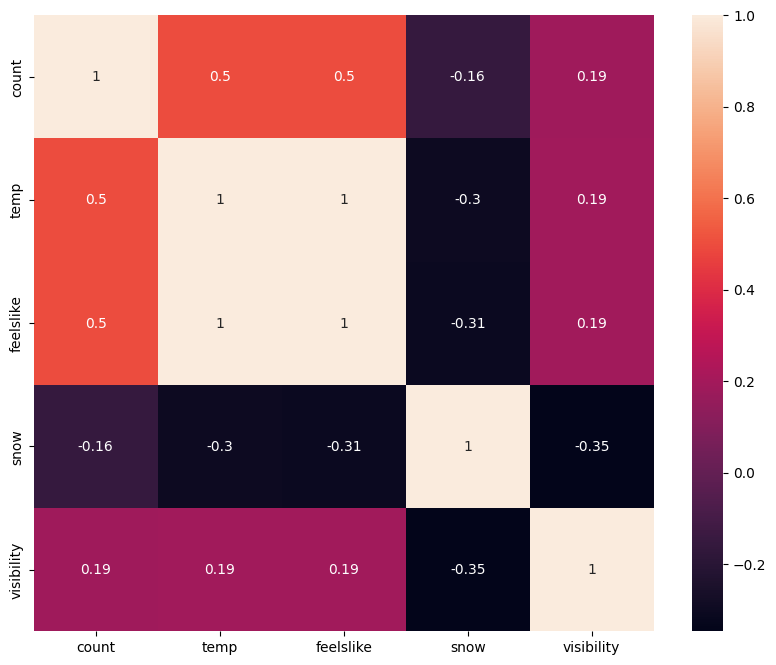

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

numerical_df = df.select_dtypes(include=[np.number])

correlation_matrix = numerical_df.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True)
plt.show()


__From the above plot we can observe strong co-relation to some attributes, like feels temparature and feels like can remove this feels like from our analysis as this can introduce multi-collenearity__

In [22]:
df = df.drop(columns=['feelslike'])

In [23]:
df.shape

(16869, 12)

__Distribution of count_of_rides__

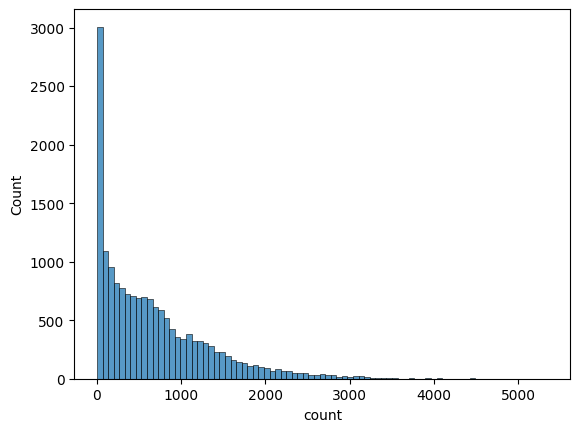

In [24]:
sns.histplot(df['count'])
plt.show()

__Numerical features analysis__

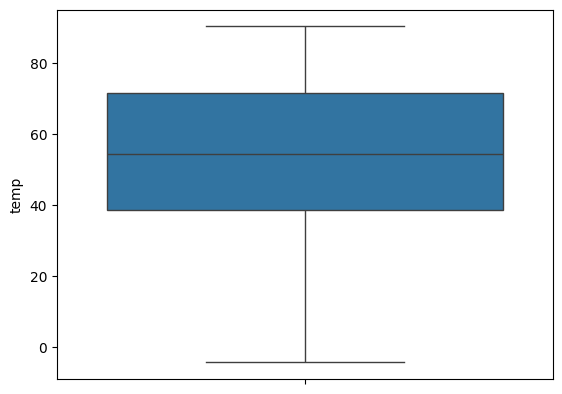

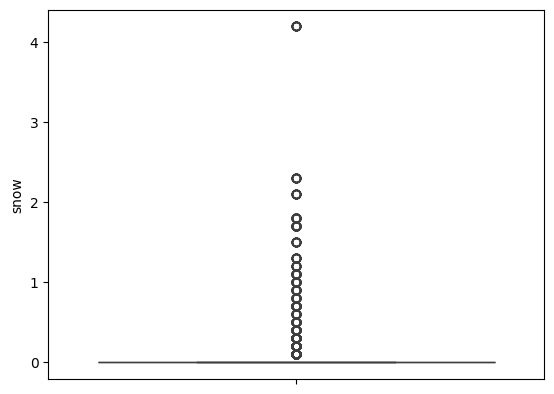

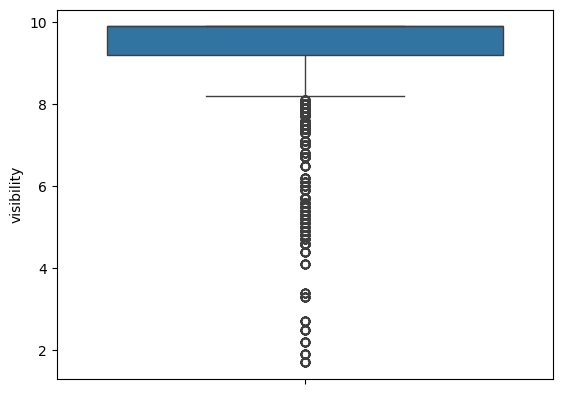

In [25]:
numerical_features = ['temp', 'snow', 'visibility']
for feature in numerical_features:
    sns.boxplot(y=df[feature])
    plt.show()


__Seems there are outliers in visibility in snow, probably, chicago being an city where weather can be abnormal its normal to see thee outliers.__

In [26]:
df.dtypes

rideable_type         category
member_casual         category
date                    object
start_in_hot_zones    category
end_in_hot_zones      category
at_stations           category
count                    int64
ISweekday             category
ISholiday             category
temp                   float64
snow                   float64
visibility             float64
dtype: object

In [27]:
cat_variables = ['rideable_type', 'member_casual', 'start_in_hot_zones', 'end_in_hot_zones', 'at_stations', 'ISweekday', 'ISholiday']

__Categorical data analysis__

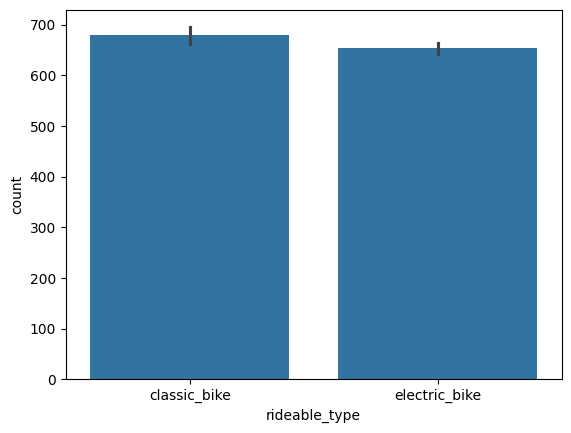

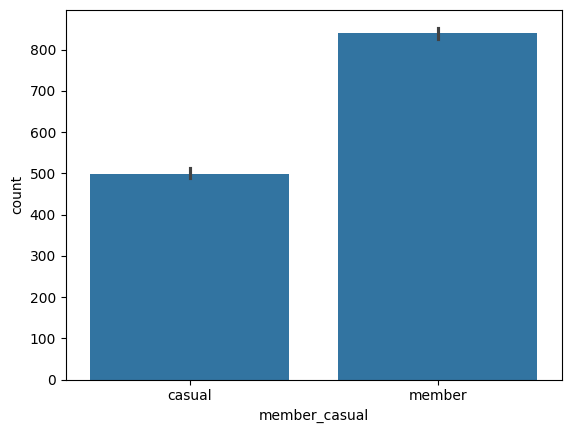

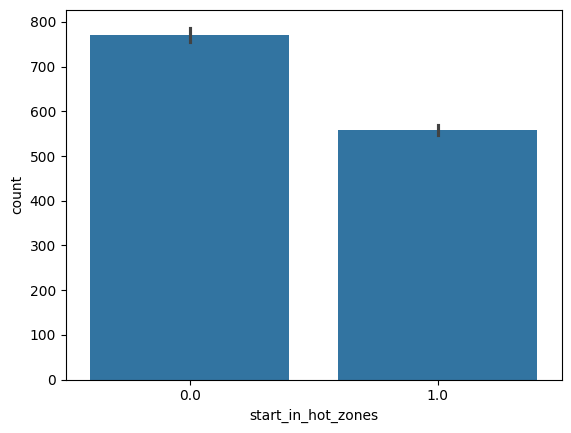

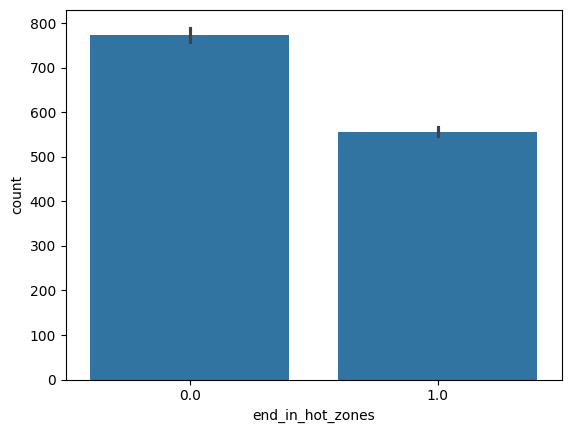

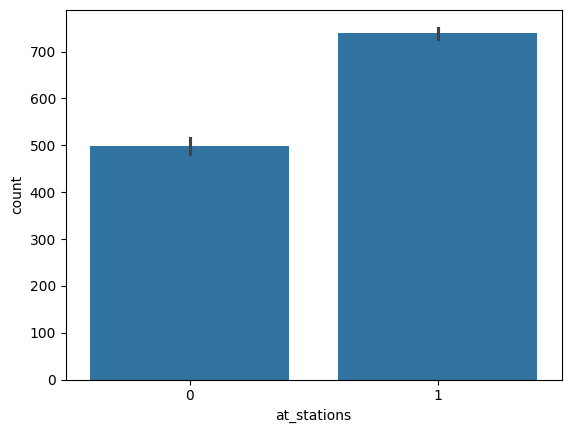

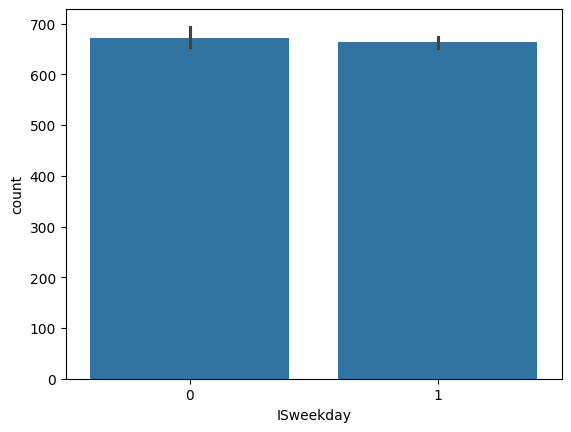

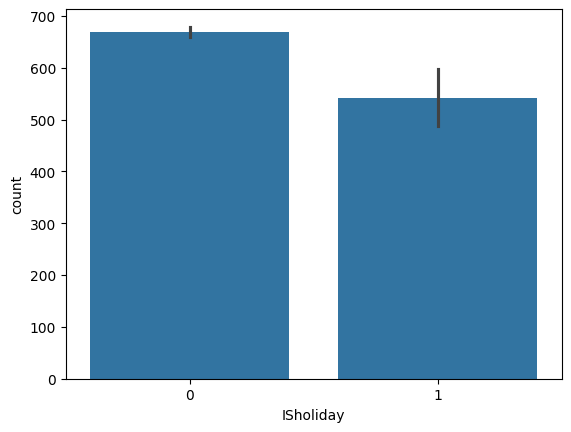

In [28]:
sns.barplot(x='rideable_type', y='count', data=df)
plt.show()
sns.barplot(x='member_casual', y='count', data=df)
plt.show()
sns.barplot(x='start_in_hot_zones', y='count', data=df)
plt.show()
sns.barplot(x='end_in_hot_zones', y='count', data=df)
plt.show()
sns.barplot(x='at_stations', y='count', data=df)
plt.show()
sns.barplot(x='ISweekday', y='count', data=df)
plt.show()
sns.barplot(x='ISholiday', y='count', data=df)
plt.show()

__time distribution with agg sum of rides per day__

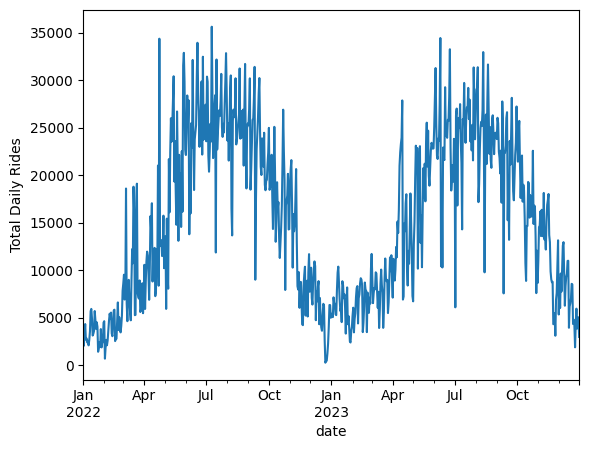

<Figure size 2000x1000 with 0 Axes>

In [29]:
df['date'] = pd.to_datetime(df['date'])

daily_rides = df.groupby('date')['count'].sum()

daily_rides.plot()

plt.ylabel('Total Daily Rides')
plt.figure(figsize=(20, 10))
plt.show()

__Hourly distribution of rides per hour__

/tmp/ipykernel_2097/2505963055.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='hour', y='count', data=data_hourly, estimator=sum, ci=None)


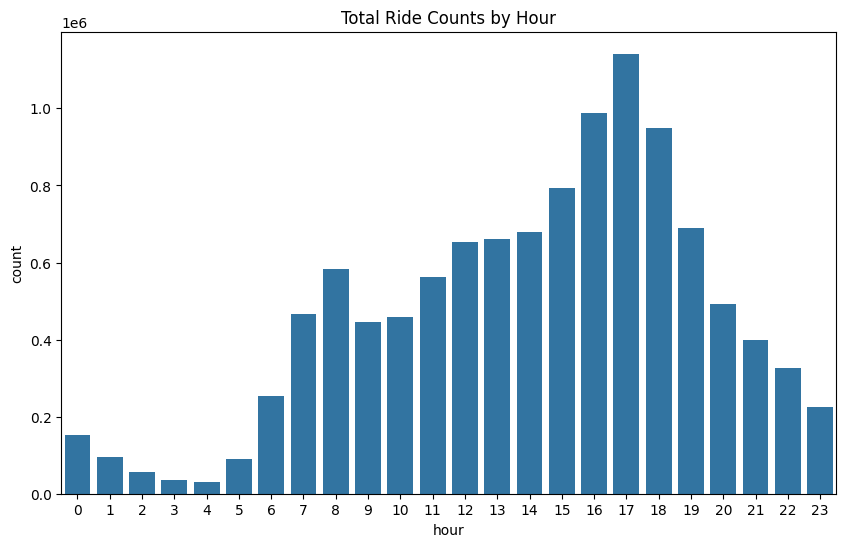

In [30]:
plt.figure(figsize=(10, 6))
sns.barplot(x='hour', y='count', data=data_hourly, estimator=sum, ci=None)
plt.title('Total Ride Counts by Hour')
plt.show()

__Just found this plot shows bad and I can not retrieve any important information from it, so just silenced it here.__

In [ ]:
#plt.figure(figsize=(12, 8))
#sns.scatterplot(x='temp', y='hour', hue='count', data=df, palette='coolwarm', size='count', sizes=(20, 400))
#plt.title('Temperature vs. Hour with Ride Counts')
#plt.show()

__Weather Conditions Analysis__

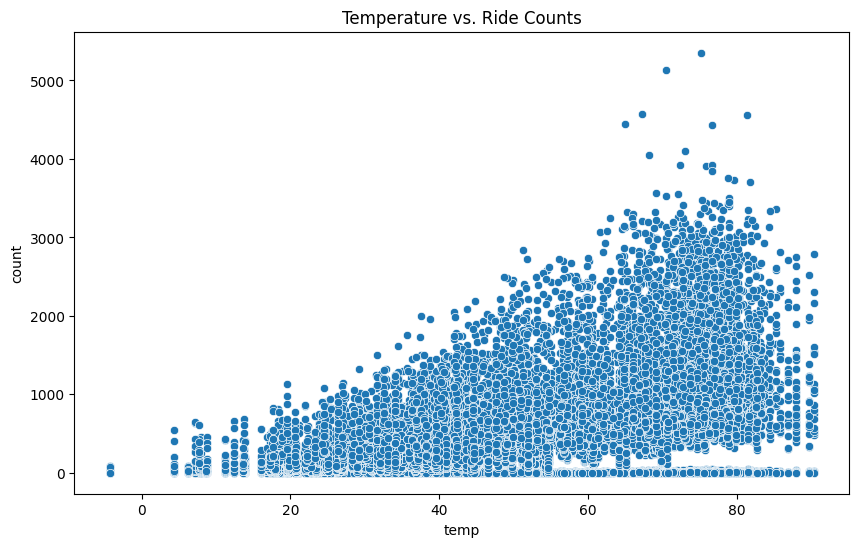

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temp', y='count', data=df)
plt.title('Temperature vs. Ride Counts')
plt.show()

__Snow vs Count__

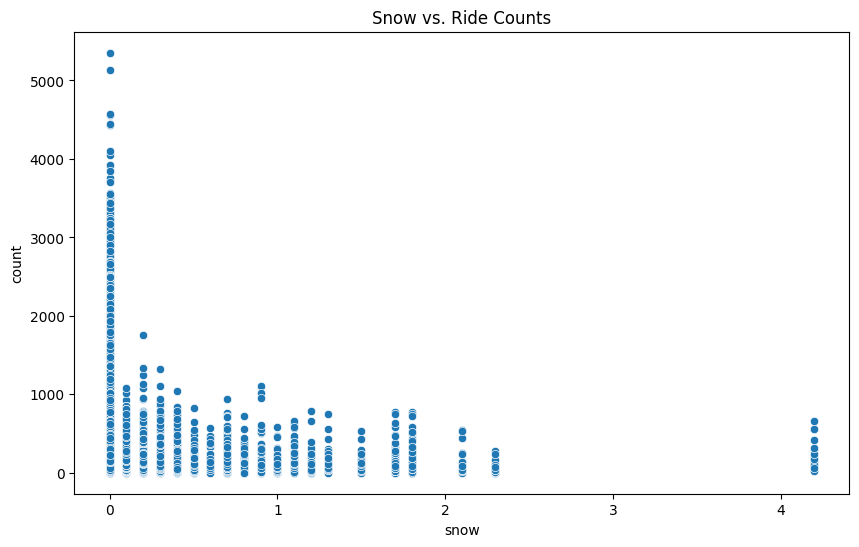

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='snow', y='count', data=df)
plt.title('Snow vs. Ride Counts')
plt.show()

__Visibility vs Count__

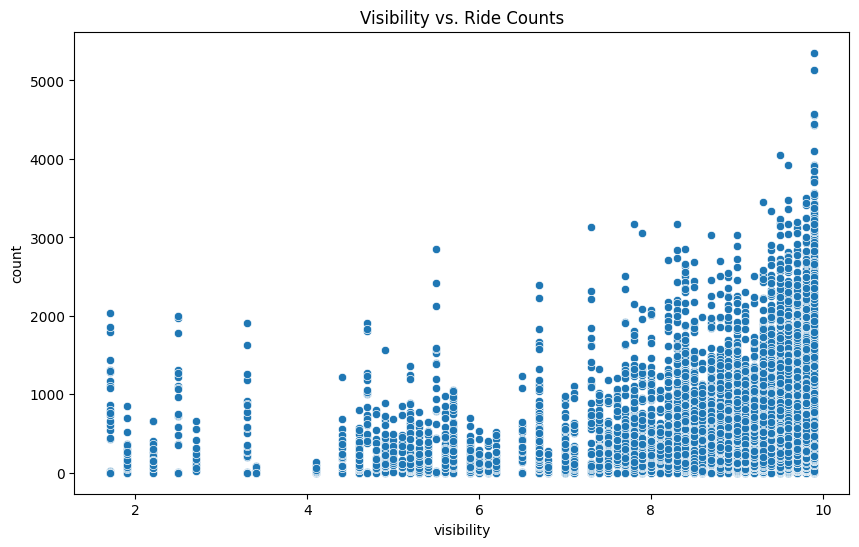

In [34]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='visibility', y='count', data=df)
plt.title('Visibility vs. Ride Counts')
plt.show()

In [32]:
# df.to_csv('data/data_daily.csv', header=True, index=False)

**Read in data and check data for modeling**

In [134]:
df=pd.read_csv('data/data_daily.csv')
df['date'] = pd.to_datetime(df['date']).dt.date
print(df.shape[0])
df.head()

16869


,rideable_type,member_casual,date,start_in_hot_zones,end_in_hot_zones,at_stations,count,ISweekday,ISholiday,temp,snow,visibility
0,classic_bike,casual,2022-01-01,0.0,0.0,0,3,0,1,34.8,0.3,4.6
1,classic_bike,casual,2022-01-01,0.0,0.0,1,192,0,1,34.8,0.3,4.6
2,classic_bike,casual,2022-01-01,0.0,1.0,1,80,0,1,34.8,0.3,4.6
3,classic_bike,casual,2022-01-01,1.0,0.0,1,87,0,1,34.8,0.3,4.6
4,classic_bike,casual,2022-01-01,1.0,1.0,0,3,0,1,34.8,0.3,4.6


**Plot and Create Logged Depedent Variable**

classic_bike 0


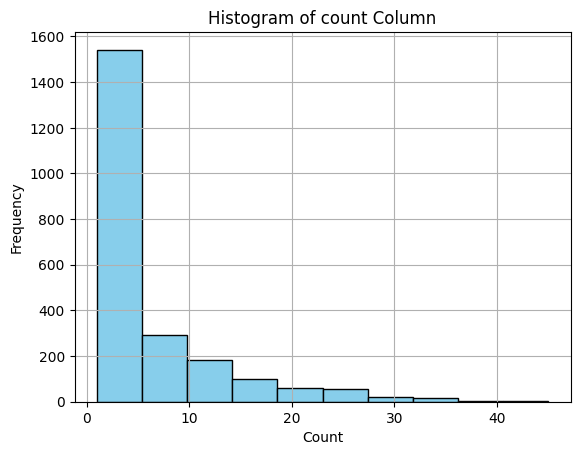

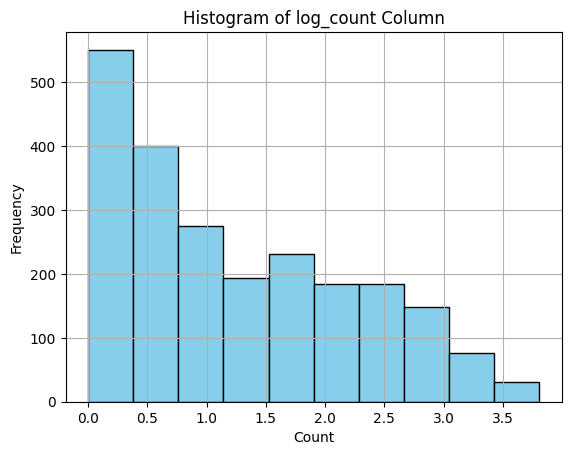

classic_bike 1


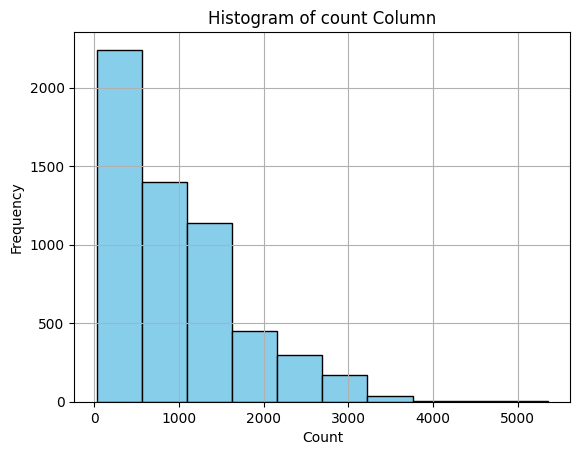

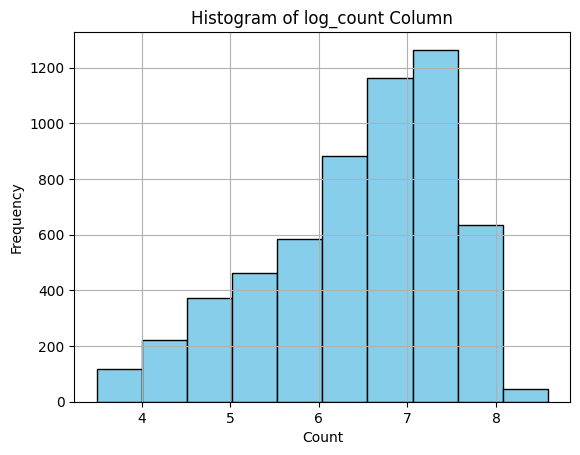

electric_bike 0


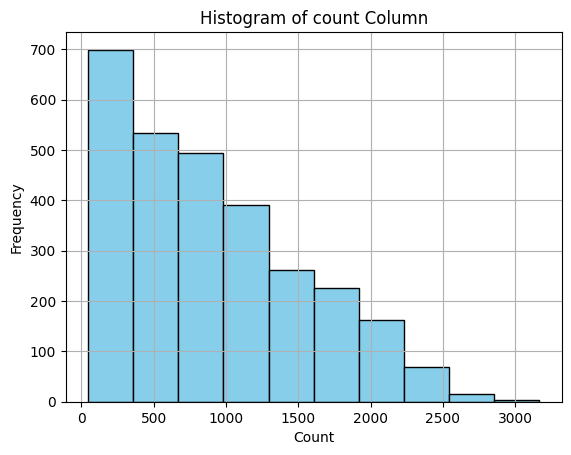

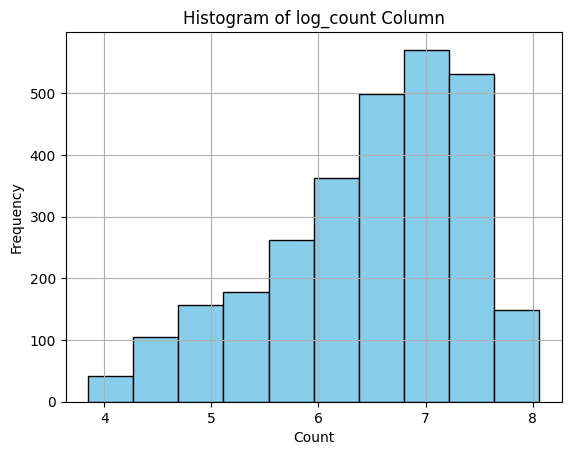

electric_bike 1


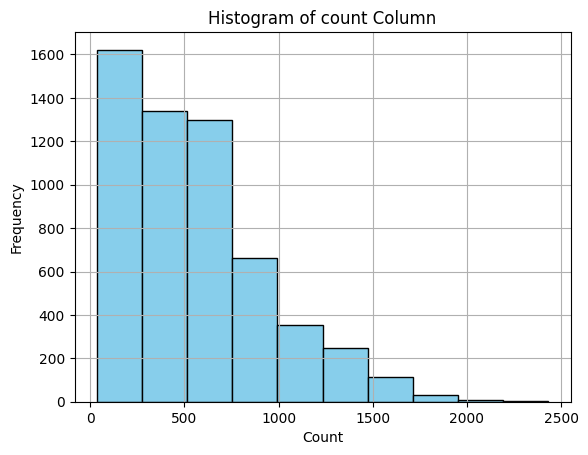

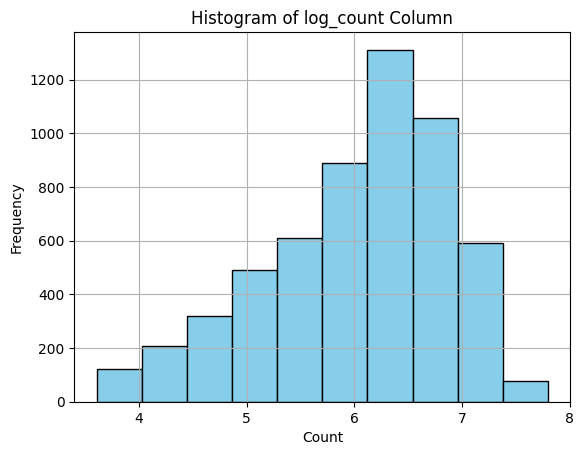

,rideable_type,member_casual,date,start_in_hot_zones,end_in_hot_zones,at_stations,count,ISweekday,ISholiday,temp,snow,visibility,log_count
0,classic_bike,casual,2022-01-01,0.0,0.0,0,3,0,1,34.8,0.3,4.6,1.098612
4,classic_bike,casual,2022-01-01,1.0,1.0,0,3,0,1,34.8,0.3,4.6,1.098612
6,classic_bike,member,2022-01-01,0.0,0.0,0,2,0,1,34.8,0.3,4.6,0.693147
10,classic_bike,member,2022-01-01,1.0,1.0,0,1,0,1,34.8,0.3,4.6,0.000000
24,classic_bike,casual,2022-01-02,0.0,0.0,0,2,0,0,23.5,1.7,7.9,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16862,electric_bike,casual,2023-12-31,1.0,1.0,1,66,0,0,34.1,0.6,7.8,4.189655
16864,electric_bike,member,2023-12-31,0.0,0.0,1,240,0,0,34.1,0.6,7.8,5.480639
16865,electric_bike,member,2023-12-31,0.0,1.0,1,103,0,0,34.1,0.6,7.8,4.634729
16866,electric_bike,member,2023-12-31,1.0,0.0,1,93,0,0,34.1,0.6,7.8,4.532599


In [135]:
import matplotlib.pyplot as plt

def hisplot(df,col):
            plt.hist(df[col], bins=10, color='skyblue', edgecolor='black')
            plt.xlabel('Count')
            plt.ylabel('Frequency')
            plt.title('Histogram of '+col+' Column')
            plt.grid(True)
            plt.show()

def remove_outliers(data):
            # Implement outlier removal logic here, for example:
            Q1 = data['log_count'].quantile(0.25)
            Q3 = data['log_count'].quantile(0.75)
            IQR = Q3 - Q1
            data = data[(data['log_count'] >= Q1 - 1.5 * IQR) & (data['log_count'] <= Q3 + 1.5 * IQR)]
            return data

log_df=pd.DataFrame()
for rideable_type in ['classic_bike', 'electric_bike']:
    for at_stations in [0, 1]:
        temp = df[(df['rideable_type'] == rideable_type) & (df['at_stations'] == at_stations)].copy()  
        temp['log_count'] = np.log(temp['count'])
        
        # Apply outlier removal function 
        temp = remove_outliers(temp)
        # plot
        print(rideable_type, at_stations)
        hisplot(temp, 'count') 
        hisplot(temp, 'log_count')  # Assuming hisplot is a function to visualize data
        log_df = pd.concat([log_df, temp], axis=0)

log_df


**Check Nulls**

In [136]:
log_df.isna().sum()

rideable_type         0
member_casual         0
date                  0
start_in_hot_zones    0
end_in_hot_zones      0
at_stations           0
count                 0
ISweekday             0
ISholiday             0
temp                  0
snow                  0
visibility            0
log_count             0
dtype: int64

## Modelling

**Train Test split**

In [137]:
X = log_df.drop(['count','log_count'],axis=1)
# y = log_df['count']
y = log_df['log_count']

In [138]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Preprocessing pipeline**

In [139]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

num_features = ['temp','visibility', 'snow']

num_pipeline = Pipeline(steps=[('scaler', StandardScaler())])

cat_features = ['rideable_type', 'member_casual', 'at_stations', 'ISweekday', 'ISholiday','start_in_hot_zones','end_in_hot_zones']
cat_pipeline = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])



preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)])

**Build Model**

__LinearRegression model__

In [141]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


linearmodel = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', LinearRegression())])

linearmodel.fit(X_train, y_train)


y_pred = linearmodel.predict(X_test)


r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R²: {r2}")
print(f"LM RMSE: {rmse}")

R²: 0.45542305661423144
LM RMSE: 1.4552348309725438


__Random Forest model__

In [142]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import numpy as np

rfmodel = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', RandomForestRegressor(n_estimators=100, random_state=42))])

rfmodel.fit(X_train, y_train)
y_pred = rfmodel.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²: {r2}")
print(f"RF RMSE: {rmse}")

R²: 0.9626041434481452
RF RMSE: 0.38134249053028807


__Plot feature importances__

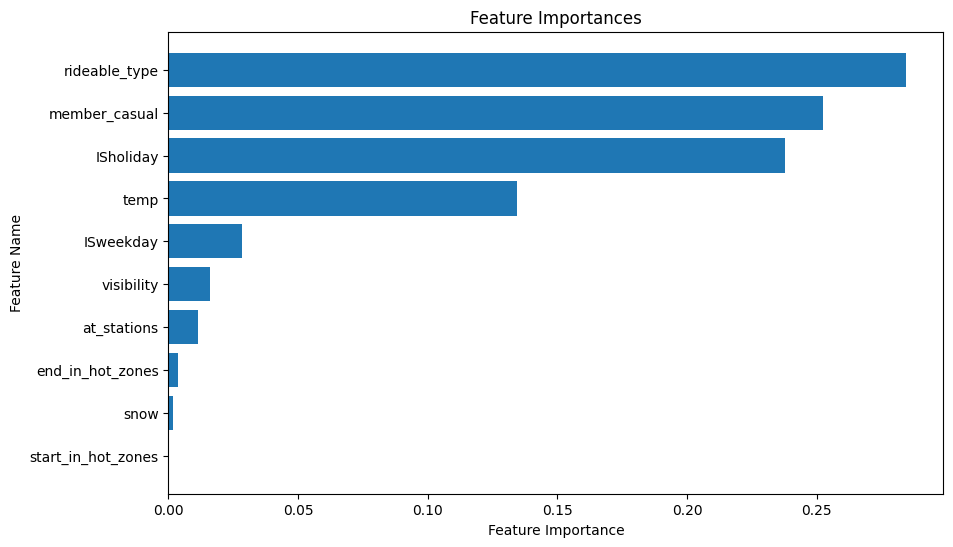

In [157]:
feature_importances = rfmodel.named_steps['model'].feature_importances_

all_feature_names = num_features + cat_features

# Now you can assign feature names to their corresponding importances
feature_importances_with_names = dict(zip(all_feature_names, feature_importances))

feature_names = list(feature_importances_with_names.keys())
importances = list(feature_importances_with_names.values())

# Sort the features based on their importances
sorted_indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importances = [importances[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
plt.show()

__KNN model__

In [143]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np


knn_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', KNeighborsRegressor(n_neighbors=5))])


knn_model.fit(X_train, y_train)


y_pred_knn = knn_model.predict(X_test)

r2 = r2_score(y_test, y_pred_knn)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_knn))

print(f"R²: {r2}")
print(f"KNN RMSE: {rmse}")

R²: 0.9425747330507911
KNN RMSE: 0.47255783415583347


__DecisionTree model__

In [146]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np


dt_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', DecisionTreeRegressor(random_state=42))])


dt_model.fit(X_train, y_train)


y_pred_dt = dt_model.predict(X_test)


r2 = r2_score(y_test, y_pred_dt)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_dt))

print(f"R²: {r2}")
print(f"DT RMSE: {rmse}")


R²: 0.938700880612609
DT RMSE: 0.48823687114074354


__SVR model__

In [145]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np


svr_model = Pipeline([
    ('preprocessor', preprocessor),
    ('svr', SVR(C=1.0, epsilon=0.1)) 
])


svr_model.fit(X_train, y_train)


y_pred_svr = svr_model.predict(X_test)


r2 = r2_score(y_test, y_pred_svr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_svr))

print(f"R²: {r2}")
print(f"svr RMSE: {rmse}")


R²: 0.9567183700247881
svr RMSE: 0.41025630095040067


__XGboost model__

In [161]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import xgboost as xgb


xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(random_state=42))
])


xgb_model.fit(X_train, y_train)


y_pred_xgb = xgb_model.predict(X_test)

r2 = r2_score(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))


n = X.shape[0]
k = X.shape[1]
adjusted_r_squared = 1 - (1 - r2) * (n - 1) / (n - k - 1)

print(f"R²: {r2}")
print(f"Adjusted R²: {adjusted_r_squared}")
print(f"XGb RMSE: {rmse}")


R²: 0.9770978063402489
Adjusted R²: 0.9770825778973874
XGb RMSE: 0.298429669095027


In [158]:

# Calculate the difference between y_test and y_test_xgb
difference = abs(y_test - y_pred_xgb)
difference.describe()

# # Plot histogram of the difference
# plt.hist(difference, bins=100, color='purple', alpha=0.5)
# plt.xlim(0,2)
# # Add labels and title
# plt.xlabel('Difference')
# plt.ylabel('Frequency')
# plt.title('Histogram of Difference between y_test and y_test_xgb')

# # Show plot
# plt.show()


count    3311.000000
mean        0.206348
std         0.215627
min         0.000094
25%         0.067106
50%         0.144589
75%         0.268187
max         2.332410
Name: log_count, dtype: float64

__Neural Network Model__

In [159]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [160]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score


model = Sequential([
    Dense(128, activation='relu', input_shape=[X_train_preprocessed.shape[1]]),
    Dense(64, activation='relu'),
    Dense(32,activation='relu'),
    Dense(1)
])


model.compile(optimizer='adam', loss='mse', metrics=['mae'])


history = model.fit(X_train_preprocessed, y_train, epochs=20, batch_size=32, validation_split=0.2)


X_test_preprocessed = preprocessor.transform(X_test)
y_pred_nn = model.predict(X_test_preprocessed).flatten()

r2_nn = r2_score(y_test, y_pred_nn)
rmse_nn = mean_squared_error(y_test, y_pred_nn, squared=False)

print(f"R²: {r2_nn}")
print(f"RMSE: {rmse_nn}")


Epoch 1/20


332/332 [==============================] - 2s 4ms/step - loss: 2.9095 - mae: 1.0637 - val_loss: 0.1998 - val_mae: 0.3333
Epoch 2/20
332/332 [==============================] - 1s 2ms/step - loss: 0.1656 - mae: 0.3039 - val_loss: 0.1693 - val_mae: 0.2968
Epoch 3/20
332/332 [==============================] - 1s 2ms/step - loss: 0.1513 - mae: 0.2896 - val_loss: 0.1723 - val_mae: 0.3111
Epoch 4/20
332/332 [==============================] - 1s 2ms/step - loss: 0.1486 - mae: 0.2887 - val_loss: 0.1630 - val_mae: 0.2961
Epoch 5/20
332/332 [==============================] - 1s 2ms/step - loss: 0.1457 - mae: 0.2856 - val_loss: 0.1625 - val_mae: 0.2952
Epoch 6/20
332/332 [==============================] - 1s 2ms/step - loss: 0.1467 - mae: 0.2847 - val_loss: 0.1542 - val_mae: 0.2935
Epoch 7/20
332/332 [==============================] - 0s 1ms/step - loss: 0.1432 - mae: 0.2832 - val_loss: 0.1575 - val_mae: 0.2936
Epoch 8/20
332/332 [==============================] - 0s 1ms/step - loss: 0.1418 - mae:

## Problems & Challenges

1. Picking useful features
2. Converting existing data types to proper data types
3. Sourcing of right weather data


## Next steps
#### Lower RMSE
More features, especially numerical features that have influence on bike usage. 
More records, including more years.

#### Geographic Infromation Combination

More useful geographic zones needed to solve stakeholders' need.
How to combine geographic information and machine learning is still in debate.


